In [118]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import librosa

import os
import json
import matplotlib.pyplot as plt
import math

In [119]:
DATA_PATH = '/Users/timur/Downloads/audio_dataset'
df = pd.read_csv(f'{DATA_PATH}/df.csv')
df.head(3)

,text,audio_id,worker_id,status,version,pool_id,task_id,path,duration,frames,rate
0,"По его словам, на вчерашний вечер у Донбанка «...",2e5fc762-6b7c-4168-8dfd-44e90e908de3,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/2e5fc762-6b7c-4168-8dfd-44e90e908d...,13.02,208320.0,16000.0
1,"Этот процесс так захватывает человека, что он ...",93b47a6a-504c-41e8-b420-1ed5b8360d0d,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/93b47a6a-504c-41e8-b420-1ed5b8360d...,15.02,240320.0,16000.0
2,Это крупнейшее левое движение Западного полуша...,19588ca3-9249-43cd-bc55-374432dffdbd,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/19588ca3-9249-43cd-bc55-374432dffd...,15.48,247680.0,16000.0


In [120]:
df.duration.describe()

count    118000.000000
mean          6.871746
std           1.927652
min           0.069250
25%           5.500000
50%           6.600000
75%           7.964062
max          22.060000
Name: duration, dtype: float64

In [164]:
df.duration.quantile(0.95)

10.4

In [165]:
def plot_waveform(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    return librosa.display.waveshow(wav, sr=sr, ax=ax)

def plot_mel(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    S = librosa.feature.melspectrogram(y=wav, sr=sr)
    return librosa.display.specshow(librosa.power_to_db(S, ref=np.max), ax=ax)

In [166]:
from collections import namedtuple

Info = namedtuple("Info", ["length", "sample_rate", "channels"])

def get_info(path: str) -> Info:
    info = torchaudio.info(path)
    if hasattr(info, 'num_frames'):
        # new version of torchaudio
        return Info(info.num_frames, info.sample_rate, info.num_channels)
    else:
        siginfo = info[0]
        return Info(siginfo.length // siginfo.channels, siginfo.rate, siginfo.channels)

In [167]:
class Audioset(Dataset):
    def __init__(self, files=None, length=None, stride=None,
                 pad=True, with_path=False, sample_rate=None,
                 channels=None, convert=False):
        """
        files should be a list [(file, length)]
        """
        self.files = files
        self.num_examples = []
        self.length = length
        self.stride = stride or length
        self.with_path = with_path
        self.sample_rate = sample_rate
        self.channels = channels
        self.convert = convert
        for file, file_length in self.files:
            if length is None:
                examples = 1
            elif file_length < length:
                examples = 1 if pad else 0
            elif pad:
                examples = int(math.ceil((file_length - self.length) / self.stride) + 1)
            else:
                examples = (file_length - self.length) // self.stride + 1
            self.num_examples.append(examples)

    def __len__(self):
        return sum(self.num_examples)

    def __getitem__(self, index):
        for (file, _), examples in zip(self.files, self.num_examples):
            if index >= examples:
                index -= examples
                continue
            num_frames = 0
            offset = 0
            if self.length is not None:
                offset = self.stride * index
                num_frames = self.length
            if torchaudio.get_audio_backend() in ['soundfile', 'sox_io']:
                out, sr = torchaudio.load(str(file),
                                          frame_offset=offset,
                                          num_frames=num_frames or -1)
            else:
                out, sr = torchaudio.load(str(file), offset=offset, num_frames=num_frames)
            target_sr = self.sample_rate or sr
            target_channels = self.channels or out.shape[0]
            if self.convert:
                out = convert_audio(out, sr, target_sr, target_channels)
            else:
                if sr != target_sr:
                    raise RuntimeError(f"Expected {file} to have sample rate of "
                                       f"{target_sr}, but got {sr}")
                if out.shape[0] != target_channels:
                    raise RuntimeError(f"Expected {file} to have sample rate of "
                                       f"{target_channels}, but got {sr}")
            if num_frames:
                out = F.pad(out, (0, num_frames - out.shape[-1]))
            if self.with_path:
                return out, file
            else:
                return out

In [168]:
class NoisyCleanSet(Dataset):
    def __init__(self, json_dir, length=None, stride=1,
                 pad=True, sample_rate=22050):
        """__init__.

        :param json_dir: directory containing both clean.json and noisy.json
        :param matching: matching function for the files
        :param length: maximum sequence length
        :param stride: the stride used for splitting audio sequences
        :param pad: pad the end of the sequence with zeros
        :param sample_rate: the signals sampling rate
        """
        self.sr = sample_rate
        noisy_json = os.path.join(json_dir, 'noisy.json')
        clean_json = os.path.join(json_dir, 'clean.json')
        with open(noisy_json, 'r') as f:
            noisy = json.load(f)
        with open(clean_json, 'r') as f:
            clean = json.load(f)

        noisy.sort()
        clean.sort()
        
        kw = {'length': length, 'stride': stride, 'pad': pad, 'sample_rate': sample_rate}
        self.clean_set = Audioset(clean, **kw)
        self.noisy_set = Audioset(noisy, **kw)

        assert len(self.clean_set) == len(self.noisy_set)

    def __getitem__(self, index):
        return self.noisy_set[index], self.clean_set[index]

    def __len__(self):
        return len(self.noisy_set)

In [169]:
dataset = NoisyCleanSet('../dataset/', length=22050*11, sample_rate=22050)

In [175]:
loader = DataLoader(dataset, batch_size=32)

In [189]:
for noisy, clean in loader:
    break

In [191]:
noisy, clean = noisy[0], clean[0]

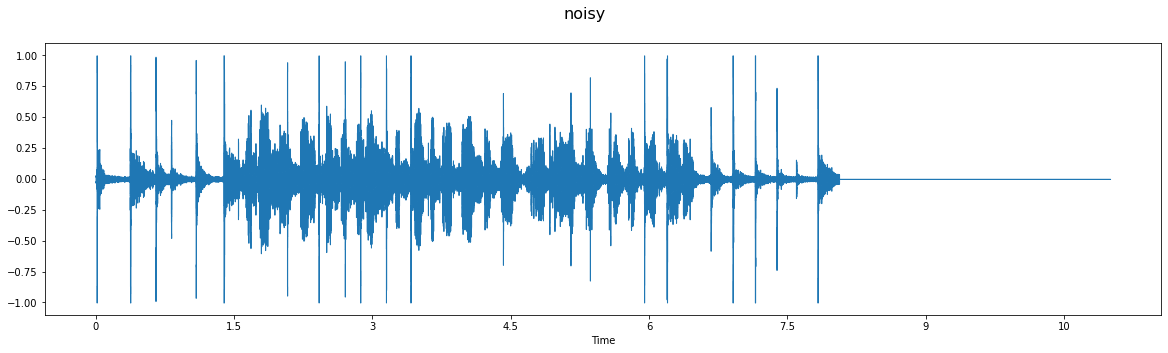

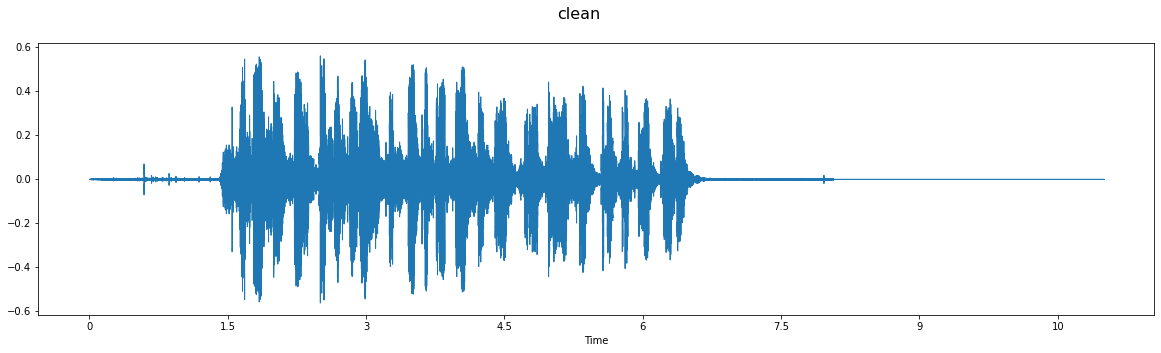

In [192]:
plot_waveform(noisy.numpy()[0], dataset.sr, label='noisy')
plot_waveform(clean.numpy()[0], dataset.sr, label='clean')

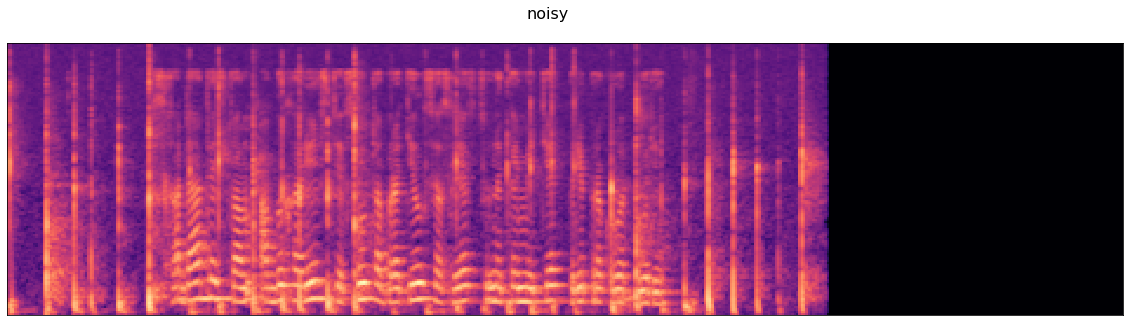

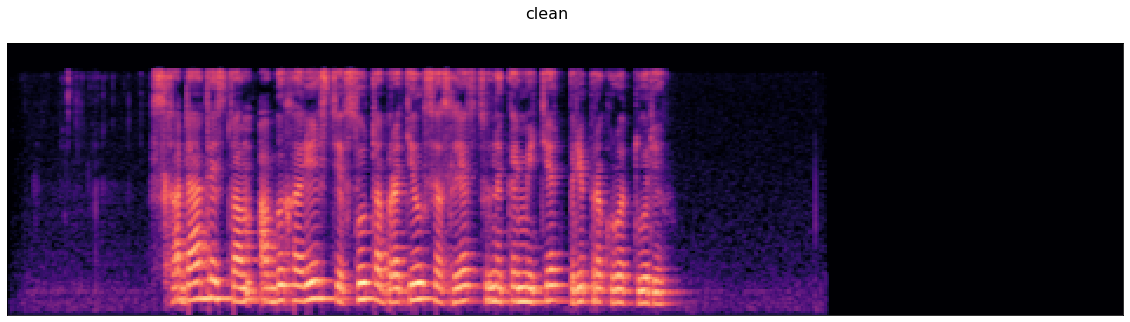

In [193]:
plot_mel(noisy.numpy()[0], dataset.sr, label='noisy')
plot_mel(clean.numpy()[0], dataset.sr, label='clean')